# 2021-01-13 • Multiple ROC's

Here we repeat the simulation multiple times (each time varying one parameter), and for each repetition calculate an ROC curve (and associated area under that curve): how well could we classify all (spike_train, VI_signal)-pairs as connected or unconnected, for a range of p-value thresholds?

## Setup

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga`<br>on **Fri 15 Jan** 2021, at 13:22 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/bcf5b10273b2837831a5a3fac4dff57c6953c5d0
) (Fri 15 Jan 2021, 00:33).

Uncommited changes to:
```
 M codebase/voltage_to_wiring_sim/support/plot_style.py
 M notebooks/2021-01-13__multiple_ROC.ipynb
```

In [4]:
from voltage_to_wiring_sim.N_to_1_experiment import N_to_1_SimParams, simulate, sim_and_eval, plot_sim_slice

In [5]:
from voltage_to_wiring_sim.sim.neuron_params import cortical_RS

## Base parameters

In [6]:
sim_params = N_to_1_SimParams(
    sim_duration = 5 * minute,
    timestep = 0.1 * ms,
    num_spike_trains = 30,
    p_connected = 0.5,
    spike_rate = 20 * Hz,
    Δg_syn = 0.8 * nS,
    τ_syn = 7 * ms,
    neuron_params = cortical_RS,
    imaging_spike_SNR = 4,
);

In [7]:
sim_data = simulate(sim_params);

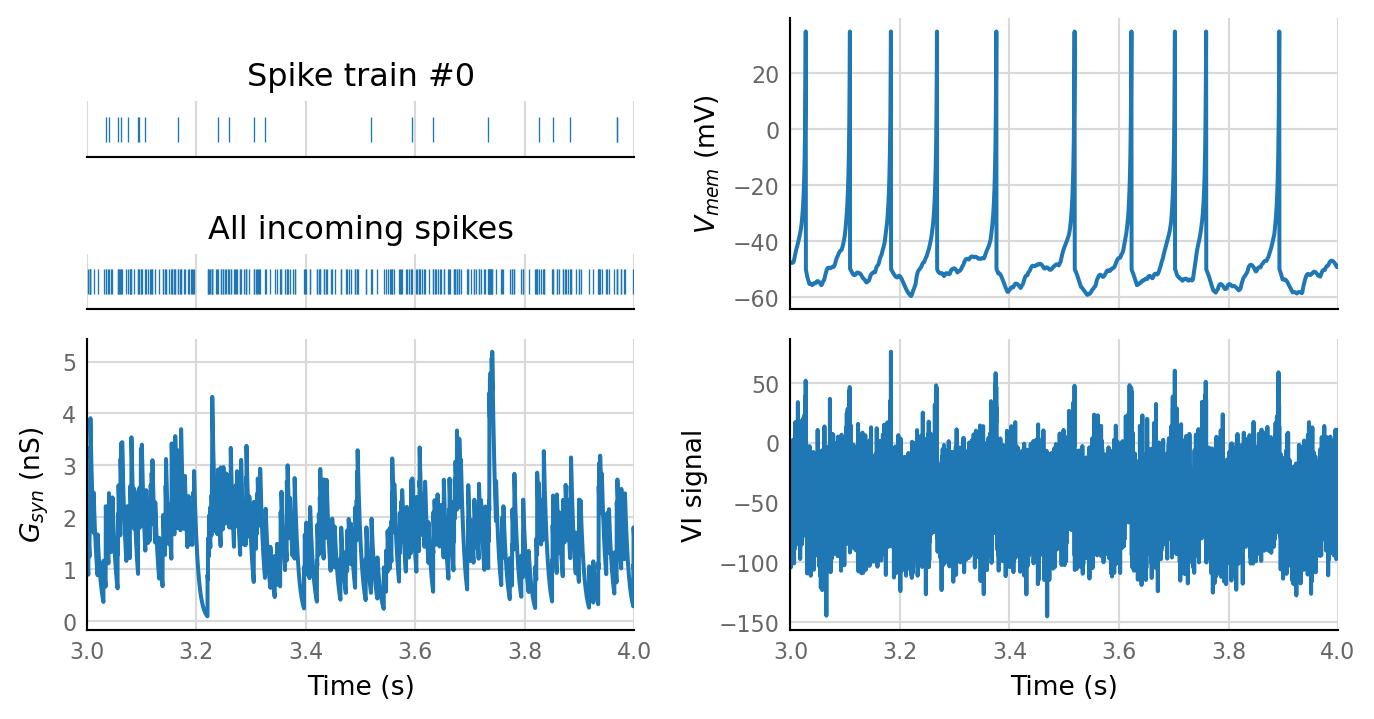

In [8]:
plot_sim_slice(sim_data, t_start=3 * second, duration=1 * second);

In [9]:
test_data, test_summaries = v.N_to_1_experiment.test_connections(sim_data);

Testing connections: 100%|██████████| 30/30 [00:06<00:00,  4.31it/s]


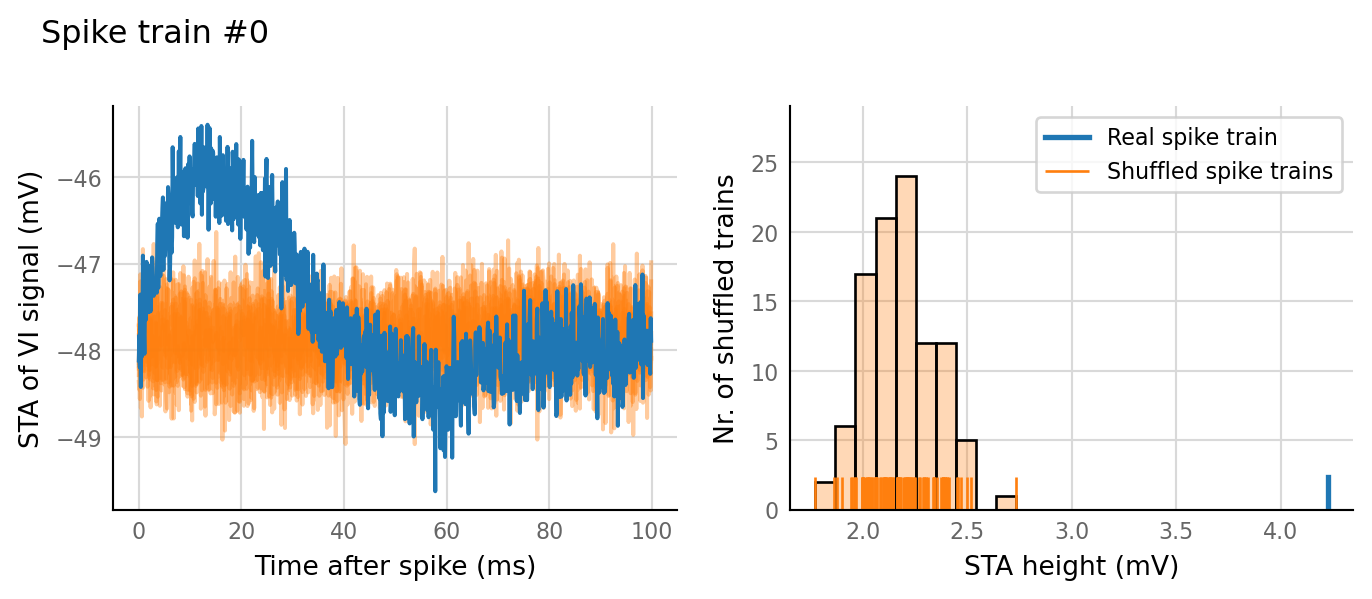

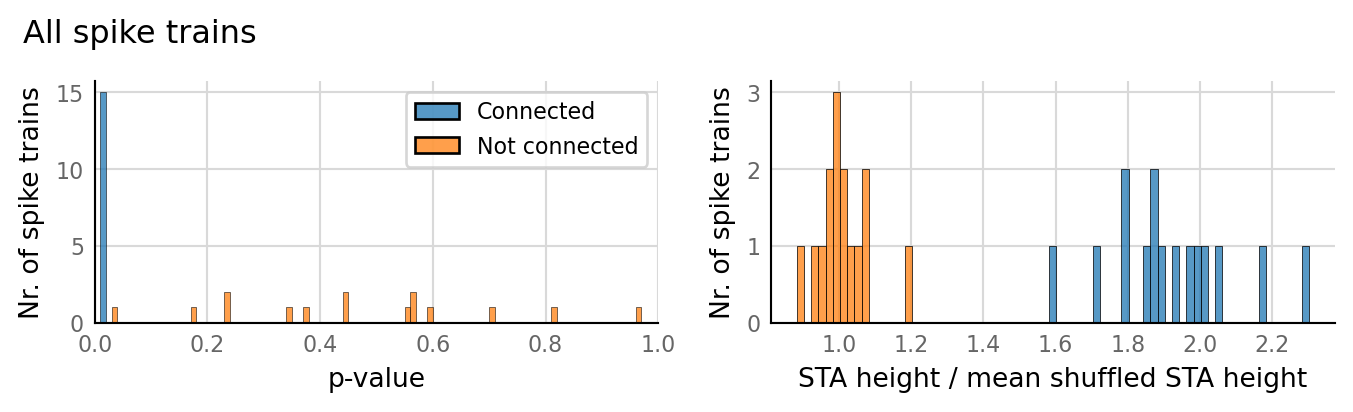

In [107]:
v.N_to_1_experiment.plot_conntest(test_data, test_summaries, sim_data)

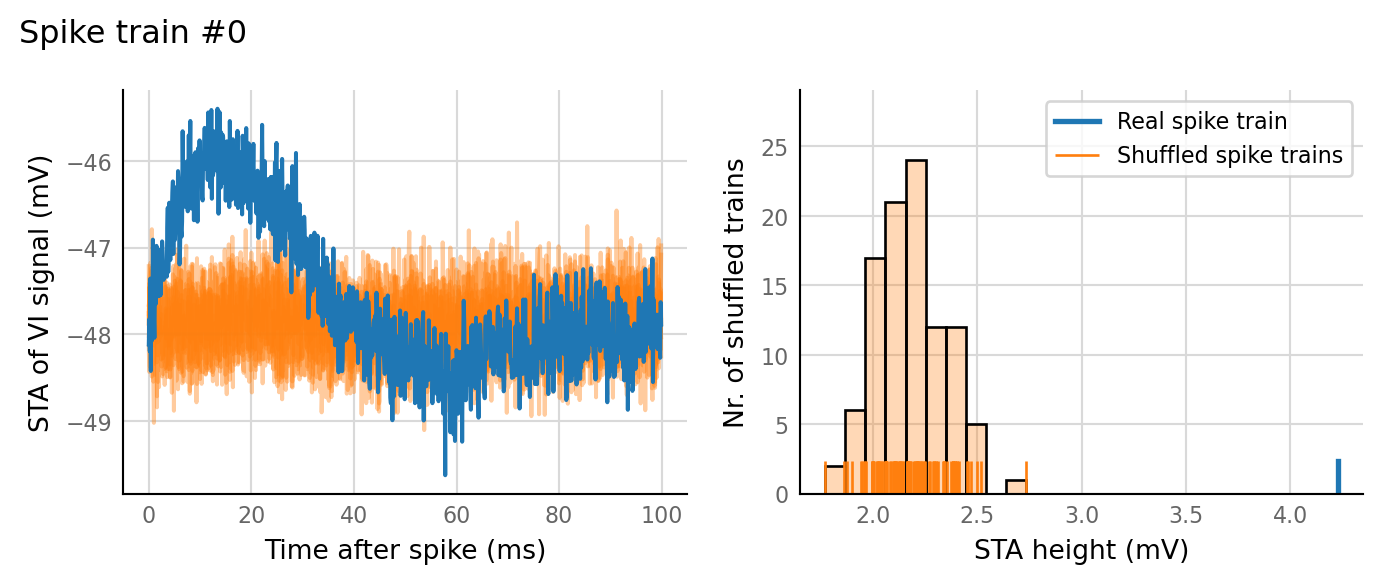

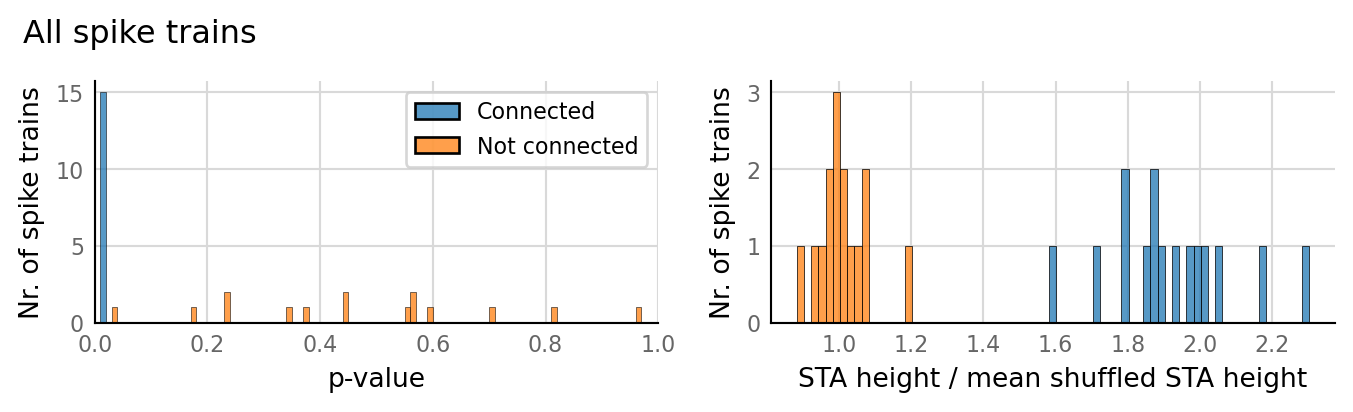

In [125]:
v.N_to_1_experiment.plot_conntest(test_data, test_summaries, sim_data)

In [140]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Fri 15 Jan** 2021, at 15:58 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/6779b97f0d729b392195fc4d577d050f2659870f
) (Fri 15 Jan 2021, 15:34).

Uncommited changes to:
```
 M codebase/voltage_to_wiring_sim/support/reproducibility.py
 M notebooks/2021-01-13__multiple_ROC.ipynb
```

Platform:

Windows-10
CPython 3.8.6 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.5
matplotlib           3.3.3
numba                0.52.0
seaborn              0.11.1
scipy                1.6.0
scikit-learn         0.24.0
preload              2.2
nptyping             1.4.0
tqdm                 4.56.0


In [141]:
!conda list

# packages in environment at C:\conda:
#
# Name                    Version                   Build  Channel
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               20.1.0           py38h294d835_2    conda-forge
async_generator           1.10                       py_0    conda-forge
atomicwrites              1.4.0              pyh9f0ad1d_0    conda-forge
attrs                     20.3.0             pyhd3deb0d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.1                      py_0    conda-forge
black                     20.8b1                     py_1    conda-forge
bleach                    3.2.1              pyh9f0ad1d_0    conda-forge
brotlipy                  0.7.0           py38h294d835_1001    conda-forge
bzip2                     1.0.8                h8ffe710_4    conda-forge
ca-certifi

puprelease                1.6.1                     dev_0    <develop>
py                        1.10.0             pyhd3deb0d_0    conda-forge
py-cpuinfo                7.0.0                    pypi_0    pypi
pycosat                   0.6.3           py38h294d835_1006    conda-forge
pycparser                 2.20               pyh9f0ad1d_2    conda-forge
pygments                  2.7.3              pyhd8ed1ab_0    conda-forge
pyopenssl                 20.0.1             pyhd8ed1ab_0    conda-forge
pyparsing                 2.4.7              pyh9f0ad1d_0    conda-forge
pyqt                      5.12.3           py38haa244fe_7    conda-forge
pyqt-impl                 5.12.3           py38h885f38d_7    conda-forge
pyqt5-sip                 4.19.18          py38h885f38d_7    conda-forge
pyqtchart                 5.12             py38h885f38d_7    conda-forge
pyqtwebengine             5.12.1           py38h885f38d_7    conda-forge
pyrsistent                0.17.3           py38h294d835_2 